# Garbage Classification with self supervised learning and swin transformer

# basic imports

In [2]:
import numpy as np 
import pandas as pd 
import os
import cv2
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import tensorflow as tf 
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D,BatchNormalization,\
                        Permute, TimeDistributed, GlobalAveragePooling2D, SeparableConv2D,\
ZeroPadding2D, Convolution2D, ZeroPadding2D, Conv2DTranspose,ReLU, UpSampling2D, Concatenate, Conv2DTranspose

# converting into a dataframe

In [3]:
root='/kaggle/input/rice-leaf-diseases/Rice_Leaf_Diease/Rice_Leaf_Diease/train/'
data={}
for i in os.listdir(root):
    for j in os.walk(root+i):
        for k in j[2]:
            data[root+i+'/'+k]=i

In [4]:
root='/kaggle/input/rice-leaf-diseases/Rice_Leaf_Diease/Rice_Leaf_Diease/valid/'

for i in os.listdir(root):
    for j in os.walk(root+i):
        for k in j[2]:
            data[root+i+'/'+k]=i

In [5]:
root='/kaggle/input/rice-leaf-diseases/Rice_Leaf_Diease/Rice_Leaf_Diease/test/'

for i in os.listdir(root):
    for j in os.walk(root+i):
        for k in j[2]:
            data[root+i+'/'+k]=i

In [6]:
data=pd.DataFrame(data.items(),columns=['path','class_'])
data=data.sample(frac=1)
data

,path,class_
8786,/kaggle/input/rice-leaf-diseases/Rice_Leaf_Die...,rice_hispa
10706,/kaggle/input/rice-leaf-diseases/Rice_Leaf_Die...,bacterial_leaf_blight
13889,/kaggle/input/rice-leaf-diseases/Rice_Leaf_Die...,leaf_scald
9799,/kaggle/input/rice-leaf-diseases/Rice_Leaf_Die...,neck_blast
16750,/kaggle/input/rice-leaf-diseases/Rice_Leaf_Die...,healthy
...,...,...
1895,/kaggle/input/rice-leaf-diseases/Rice_Leaf_Die...,bacterial_leaf_blight
342,/kaggle/input/rice-leaf-diseases/Rice_Leaf_Die...,neck_blast
12521,/kaggle/input/rice-leaf-diseases/Rice_Leaf_Die...,healthy
4424,/kaggle/input/rice-leaf-diseases/Rice_Leaf_Die...,brown_spot


In [7]:
def split_data(data,ratio):
    last=int(len(data)*ratio)
    return data[:last], data[last:]

In [8]:
train,test=split_data(data,.7)

In [9]:
train.to_csv('train.csv',index=False)
test.to_csv('test.csv',index=False)

# dataset balancing with oversampling

In [10]:
train["class_"].value_counts()

leaf_blast               1499
tungro                   1439
leaf_scald               1428
healthy                  1339
sheath_blight            1316
brown_spot               1292
narrow_brown_spot        1276
bacterial_leaf_blight    1225
rice_hispa               1166
neck_blast                931
Name: class_, dtype: int64

# data dividing

In [12]:
train,valid=split_data(train,.8)

In [13]:
train

,path,class_
8786,/kaggle/input/rice-leaf-diseases/Rice_Leaf_Die...,rice_hispa
10706,/kaggle/input/rice-leaf-diseases/Rice_Leaf_Die...,bacterial_leaf_blight
13889,/kaggle/input/rice-leaf-diseases/Rice_Leaf_Die...,leaf_scald
9799,/kaggle/input/rice-leaf-diseases/Rice_Leaf_Die...,neck_blast
16750,/kaggle/input/rice-leaf-diseases/Rice_Leaf_Die...,healthy
...,...,...
7860,/kaggle/input/rice-leaf-diseases/Rice_Leaf_Die...,leaf_blast
3372,/kaggle/input/rice-leaf-diseases/Rice_Leaf_Die...,sheath_blight
14648,/kaggle/input/rice-leaf-diseases/Rice_Leaf_Die...,rice_hispa
5330,/kaggle/input/rice-leaf-diseases/Rice_Leaf_Die...,healthy


In [14]:
train["class_"].value_counts()

leaf_blast               996
leaf_scald               901
tungro                   898
healthy                  866
sheath_blight            850
brown_spot               815
narrow_brown_spot        793
bacterial_leaf_blight    785
rice_hispa               752
neck_blast               606
Name: class_, dtype: int64

In [15]:
valid

,path,class_
12140,/kaggle/input/rice-leaf-diseases/Rice_Leaf_Die...,brown_spot
9015,/kaggle/input/rice-leaf-diseases/Rice_Leaf_Die...,rice_hispa
6811,/kaggle/input/rice-leaf-diseases/Rice_Leaf_Die...,leaf_scald
17814,/kaggle/input/rice-leaf-diseases/Rice_Leaf_Die...,leaf_scald
4298,/kaggle/input/rice-leaf-diseases/Rice_Leaf_Die...,brown_spot
...,...,...
52,/kaggle/input/rice-leaf-diseases/Rice_Leaf_Die...,neck_blast
8196,/kaggle/input/rice-leaf-diseases/Rice_Leaf_Die...,leaf_blast
6639,/kaggle/input/rice-leaf-diseases/Rice_Leaf_Die...,leaf_scald
5725,/kaggle/input/rice-leaf-diseases/Rice_Leaf_Die...,narrow_brown_spot


In [16]:
valid["class_"].value_counts()

tungro                   254
leaf_scald               234
brown_spot               220
leaf_blast               220
narrow_brown_spot        219
bacterial_leaf_blight    201
sheath_blight            195
healthy                  194
rice_hispa               185
neck_blast               144
Name: class_, dtype: int64

In [17]:
test

,path,class_
7674,/kaggle/input/rice-leaf-diseases/Rice_Leaf_Die...,leaf_blast
8918,/kaggle/input/rice-leaf-diseases/Rice_Leaf_Die...,rice_hispa
3700,/kaggle/input/rice-leaf-diseases/Rice_Leaf_Die...,brown_spot
151,/kaggle/input/rice-leaf-diseases/Rice_Leaf_Die...,neck_blast
5184,/kaggle/input/rice-leaf-diseases/Rice_Leaf_Die...,healthy
...,...,...
1895,/kaggle/input/rice-leaf-diseases/Rice_Leaf_Die...,bacterial_leaf_blight
342,/kaggle/input/rice-leaf-diseases/Rice_Leaf_Die...,neck_blast
12521,/kaggle/input/rice-leaf-diseases/Rice_Leaf_Die...,healthy
4424,/kaggle/input/rice-leaf-diseases/Rice_Leaf_Die...,brown_spot


In [18]:
test["class_"].value_counts()

leaf_blast               664
leaf_scald               628
tungro                   611
brown_spot               568
sheath_blight            550
healthy                  543
bacterial_leaf_blight    537
narrow_brown_spot        522
rice_hispa               520
neck_blast               391
Name: class_, dtype: int64

In [19]:
batch_size = 32
size=224
epoch=50
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='path',
    y_col='class_',
    target_size=(size, size),
    batch_size=batch_size,
    class_mode="input"
    )
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = train_datagen.flow_from_dataframe(
    dataframe=valid,
    x_col='path',
    y_col='class_',
    target_size=(size, size),
    batch_size=batch_size,
    class_mode="input"
    )

Found 8262 validated image filenames.
Found 2066 validated image filenames.


# generators for autoencoder

# se for encoder

In [20]:
def se_block_enc(inputs,alpha):
    input_channels = inputs.shape[-1]
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(units=alpha, activation="relu")(x)    
    x = tf.keras.layers.Dense(units=input_channels, activation="sigmoid")(x)    
    x = tf.reshape(x, [-1, 1, 1, input_channels])
    x = inputs * x
    return x

# defining auto-encoder

In [21]:
# ENCODER
input_img = Input(shape=(size,size, 3))  
x = Conv2D(48, (3, 3), activation='relu', padding='same')(input_img)
x=se_block_enc(x,20)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(96, (3, 3), activation='relu', padding='same')(x)
x=se_block_enc(x,30)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
x=se_block_enc(x,50)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(32, (1, 1), activation='relu', padding='same')(x)

# Bottolneck
latentSize = (28,28,32)

# DECODER
direct_input = Input(shape=latentSize)
x = Conv2D(192, (1, 1), activation='relu', padding='same')(direct_input)
x = UpSampling2D((2, 2))(x)
x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(96, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(48, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# COMPILE
encoder = Model(input_img, encoded)
decoder = Model(direct_input, decoded)
autoencoder = Model(input_img, decoder(encoded))

In [22]:
autoencoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 48  1344        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 global_average_pooling2d (Glob  (None, 48)          0           ['conv2d[0][0]']                 
 alAveragePooling2D)                                                                        

# complining auto-encoder

In [21]:
autoencoder.compile(optimizer=tf.keras.optimizers.experimental.Adamax(), loss='binary_crossentropy')
history = autoencoder.fit_generator(train_generator,
                                 validation_data= valid_generator,
        epochs = epoch, verbose=2)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/25
323/323 - 643s - loss: 0.4538 - val_loss: 0.4273 - 643s/epoch - 2s/step
Epoch 2/25
323/323 - 489s - loss: 0.4274 - val_loss: 0.4236 - 489s/epoch - 2s/step
Epoch 3/25
323/323 - 495s - loss: 0.4234 - val_loss: 0.4215 - 495s/epoch - 2s/step
Epoch 4/25
323/323 - 499s - loss: 0.4225 - val_loss: 0.4208 - 499s/epoch - 2s/step
Epoch 5/25
323/323 - 498s - loss: 0.4220 - val_loss: 0.4206 - 498s/epoch - 2s/step
Epoch 6/25
323/323 - 542s - loss: 0.4218 - val_loss: 0.4199 - 542s/epoch - 2s/step
Epoch 7/25
323/323 - 555s - loss: 0.4209 - val_loss: 0.4196 - 555s/epoch - 2s/step
Epoch 8/25
323/323 - 551s - loss: 0.4222 - val_loss: 0.4217 - 551s/epoch - 2s/step
Epoch 9/25
323/323 - 562s - loss: 0.4209 - val_loss: 0.4194 - 562s/epoch - 2s/step
Epoch 10/25
323/323 - 563s - loss: 0.4203 - val_loss: 0.4192 - 563s/epoch - 2s/step
Epoch 11/25
323/323 - 562s - loss: 0.4202 - val_loss: 0.4190 - 562s/epoch - 2s/step
Epoch 12/25
323/323 - 554s - loss: 0.4201 - val_loss: 0.4187 - 554s/epoch - 2s/step
E

# auto-encoder loss graph

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-o" (-> color='g'). The keyword argument will take precedence.
  if sys.path[0] == "":


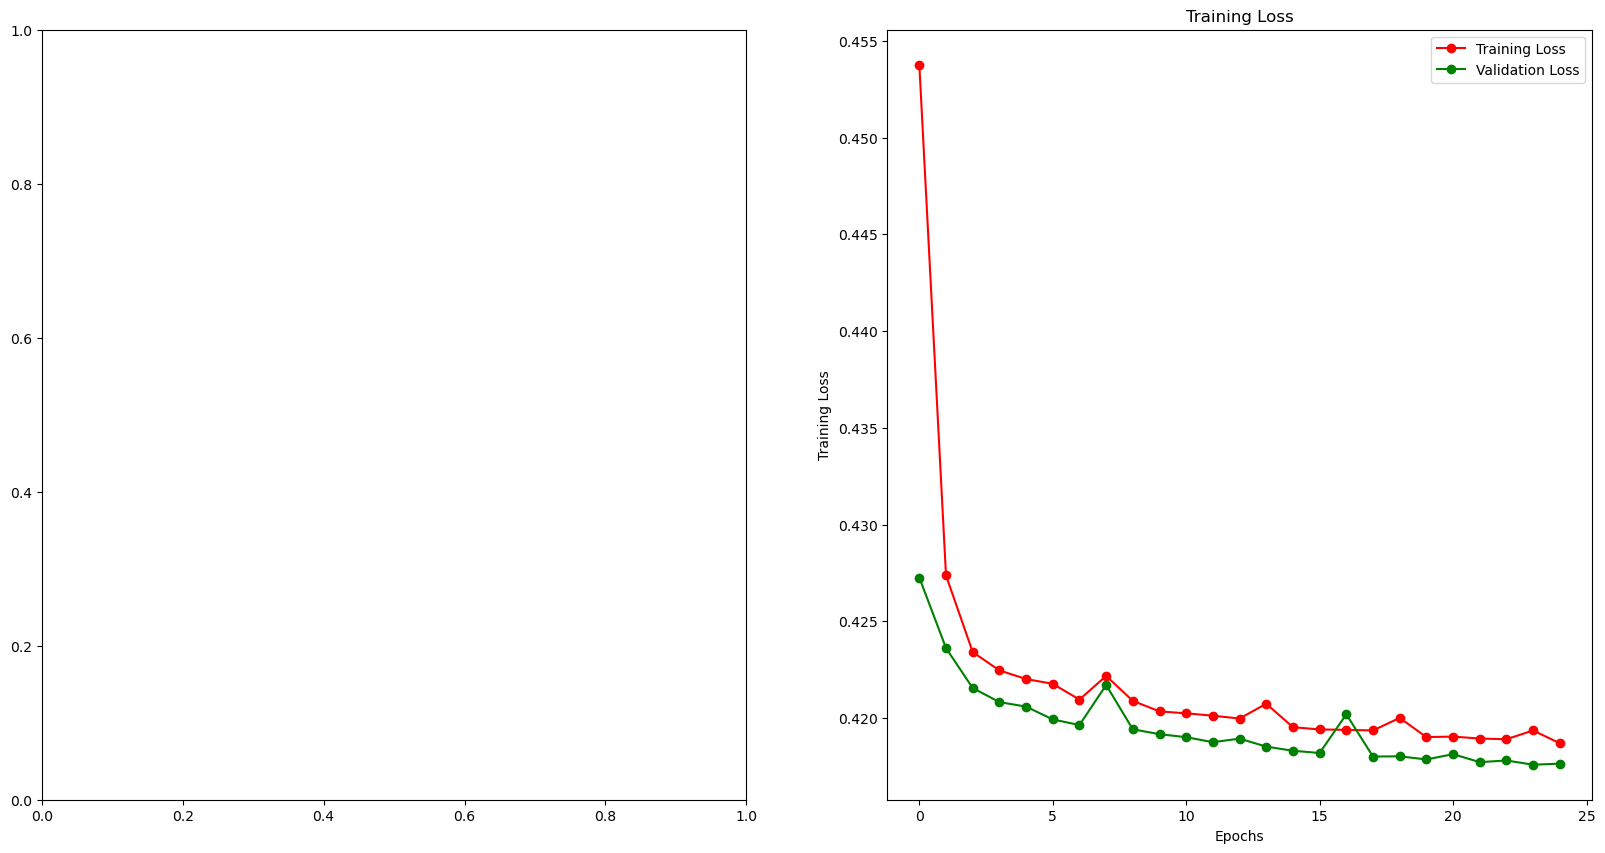

In [22]:
epochs = list(range(len(history.history['loss'])))
fig , ax = plt.subplots(1,2)

train_loss = history.history['loss']

val_loss = history.history['val_loss']

fig.set_size_inches(20,10)



ax[1].plot(epochs , train_loss , 'g-o' ,color='r', label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'go-' , label = 'Validation Loss')
ax[1].set_title('Training Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training Loss")
plt.show()

# saving model

In [23]:
autoencoder.save("auto_encoder.h5")
encoder.save('encoder.h5')
decoder.save('decoder.h5')

# checking the performance of auto-encoder

1/1 [==============================] - 6s 6s/step


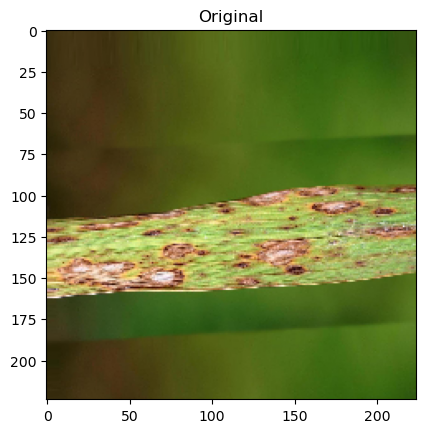

In [24]:
orig = cv2.imread(test.iloc[0]['path']) 
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
orig=orig* 1.0 / 255.0
orig = cv2.resize(orig, (size, size),
               interpolation = cv2.INTER_NEAREST)
img = tf.expand_dims(orig, axis=0)

encoder_output=encoder.predict(img)
plt.title('Original')
plt.imshow(orig)

In [25]:
encoder_output.shape

(1, 28, 28, 32)

Text(0.5, 1.0, 'a samplt output of encoded image')

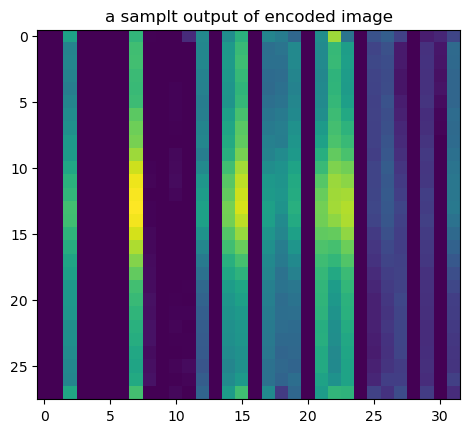

In [26]:
plt.imshow(encoder_output[0][0]) # a channel output shown in plot
plt.title("a samplt output of encoded image")

In [27]:
original_output=decoder.predict(encoder_output)

1/1 [==============================] - 1s 747ms/step


Text(0.5, 1.0, 'reconstructed image')

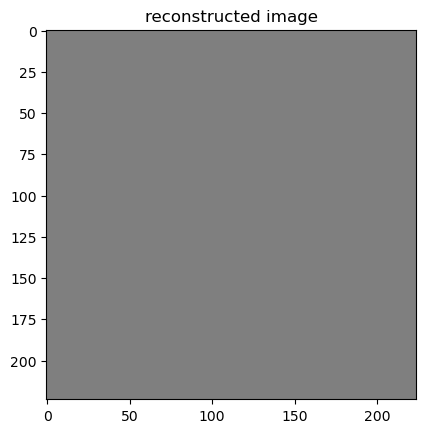

In [28]:
plt.imshow(original_output[0])
plt.title("reconstructed image")

In [29]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)
train_images = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='path',
    y_col='class_',
    batch_size=batch_size,
    target_size=(size, size),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=42,
)
valid_images=valid_datagen.flow_from_dataframe(
    dataframe=valid,
    x_col='path',
    y_col='class_',
    batch_size=batch_size,
    target_size=(size, size),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=42,
)

Found 8262 validated image filenames belonging to 10 classes.
Found 2066 validated image filenames belonging to 10 classes.


# freezing encoder

In [30]:
for i in encoder.layers:
    i.freeze=True

# basic functions

In [31]:
import tensorflow_hub as hub
def get_from_hub(model_url):
    inputs = tf.keras.Input((224, 224, 3))
    hub_module = hub.KerasLayer(model_url,trainable=False)
    outputs = hub_module(inputs)
    return tf.keras.Model(inputs, outputs)

In [32]:
def se_block(inputs):
    input_channels = inputs.shape[-1]
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(units=len(train_images.class_indices.keys()), activation="relu")(x)    
    x = tf.keras.layers.Dense(units=input_channels, activation="sigmoid")(x)    
    x = tf.reshape(x, [-1, 1, 1, input_channels])
    x = inputs * x
    return x

In [33]:
swin=get_from_hub('https://tfhub.dev/sayakpaul/swin_large_patch4_window7_224_in22k_fe/1')

# fine tuning swin transformer

In [34]:
from tensorflow.keras import regularizers
x=swin.output
x=tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(32, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dense(256,activation='relu')(x)
x_swin = Dense(128, activation='relu')(x)

# fine tunine encoder

In [35]:
def get_model(base_model):
    x = tf.keras.layers.GlobalAveragePooling2D()(se_block(base_model.output))
    x=tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(512, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dense(256,activation='relu')(x)
    return Dense(128,activation='relu')(x)

In [36]:
x_encoder=get_model(encoder)

# final model

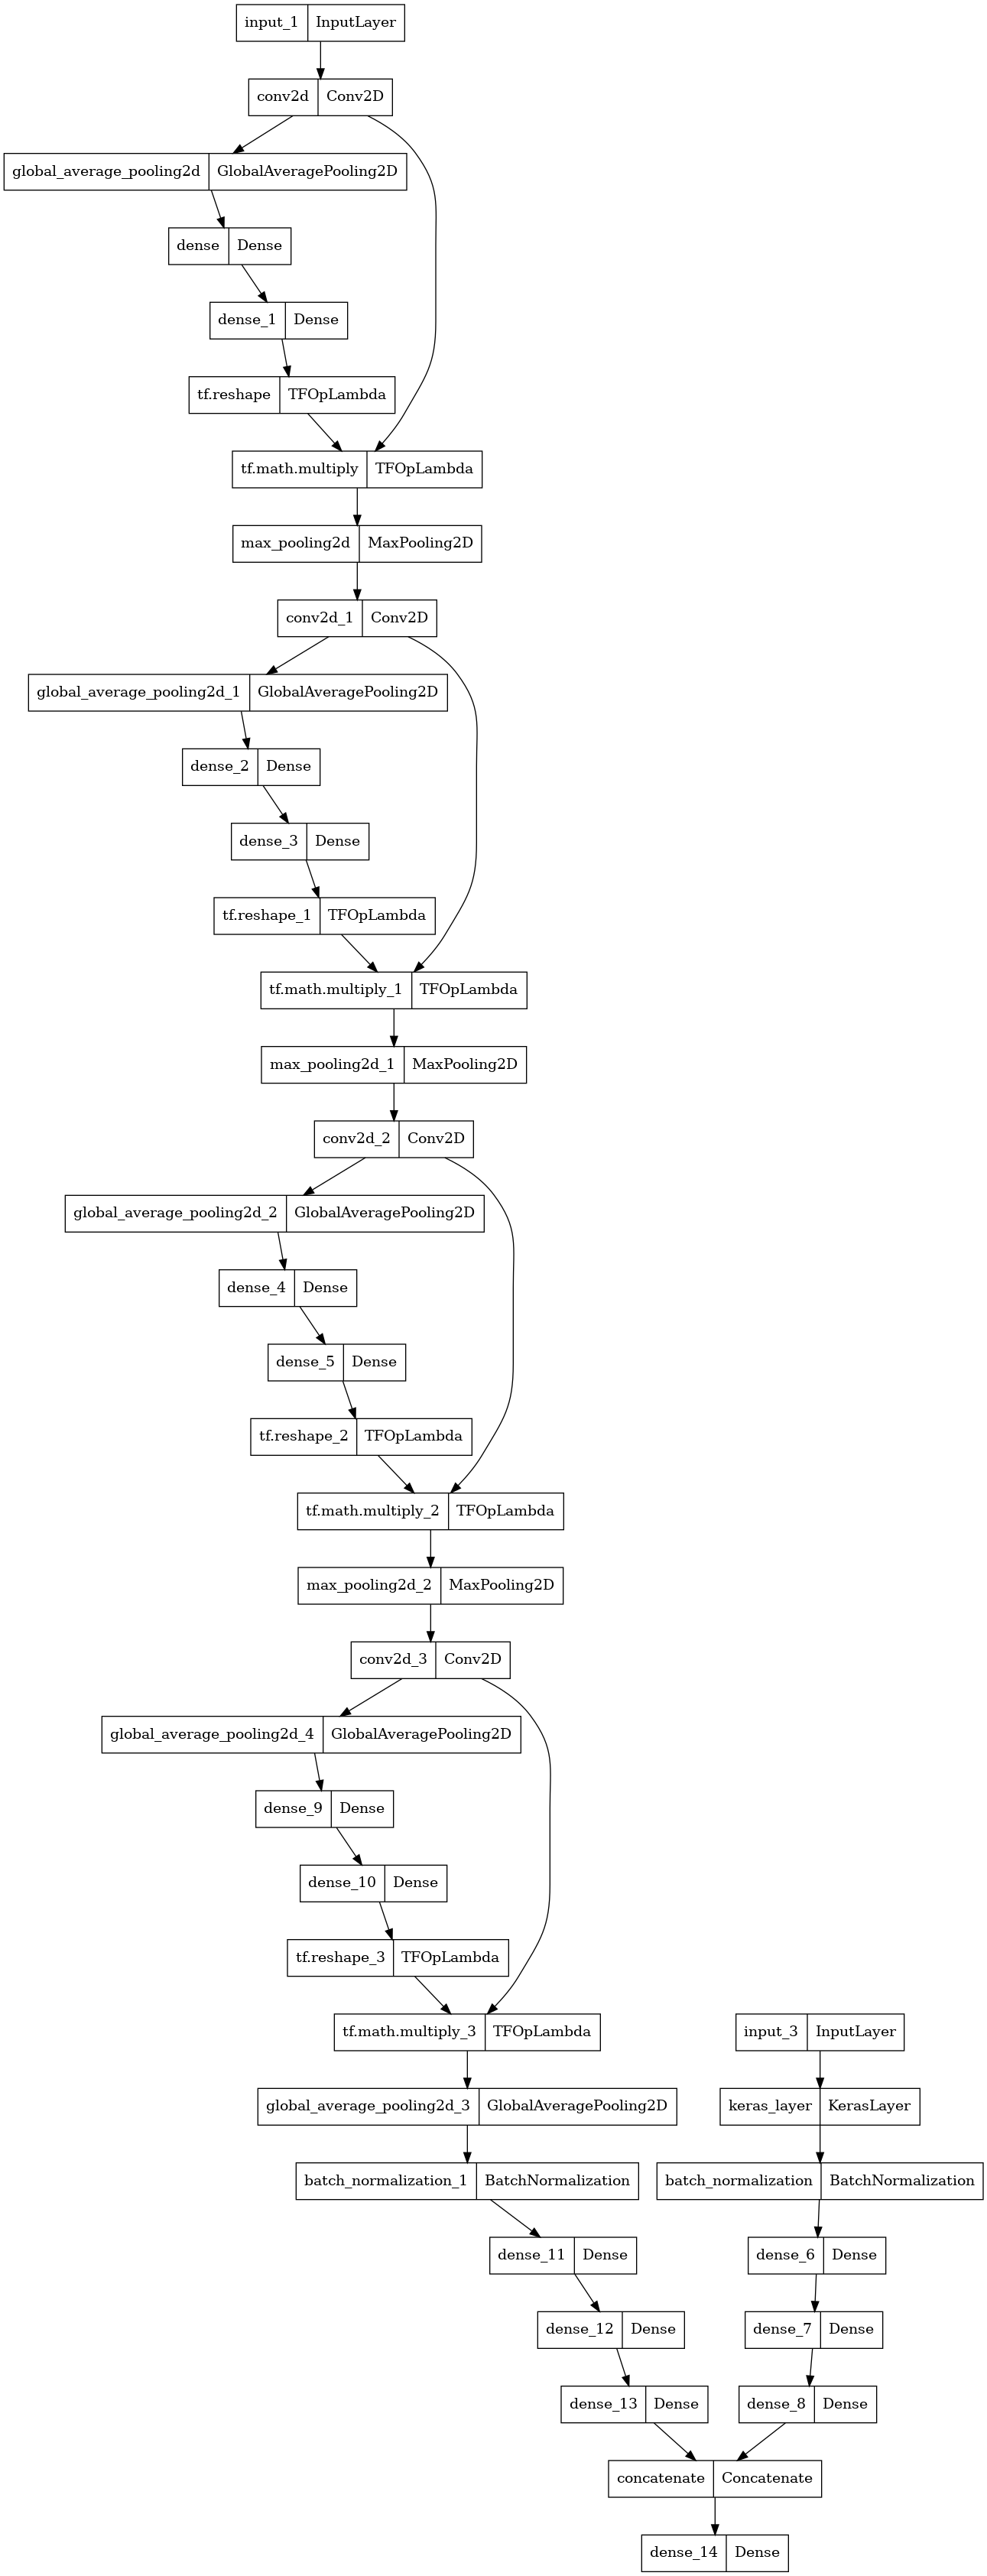

In [37]:
from tensorflow.keras.layers import concatenate
concatenated=concatenate([x_encoder,x_swin])
bigmodel_prediction = Dense(len(train_images.class_indices), activation='softmax')(concatenated)
model = Model([encoder.input,swin.input], bigmodel_prediction)
from tensorflow.keras.utils import plot_model
plot_model(model)

In [38]:
trainable_params = sum([v.numpy().size for v in model.trainable_variables])
non_trainable_params = sum([v.numpy().size for v in model.non_trainable_variables])
print("trainable parametres: "+ str(trainable_params) + " non trainable parametres: "+ str(non_trainable_params))

trainable parametres: 520520 non trainable parametres: 194998612


# generators for actual model

In [39]:
def generator_two_img(gen):
    while True:
        X1i = gen.next()
        yield [X1i[0],X1i[0]], X1i[1]

# training model

In [40]:
model.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.experimental.Adamax(),metrics=['accuracy'])

In [41]:
history = model.fit(
    generator_two_img(train_images),
    validation_data=generator_two_img(valid_images), 
    validation_steps=valid_images.n//batch_size,
    validation_batch_size=batch_size,
    steps_per_epoch=train_generator.n//batch_size,
    batch_size=batch_size,
    epochs=epoch,
)

Epoch 1/50
258/258 [==============================] - 656s 2s/step - loss: 1.7240 - accuracy: 0.7616 - val_loss: 1.1090 - val_accuracy: 0.8647
Epoch 2/50
258/258 [==============================] - 505s 2s/step - loss: 0.8894 - accuracy: 0.8869 - val_loss: 0.7476 - val_accuracy: 0.9111
Epoch 3/50
258/258 [==============================] - 502s 2s/step - loss: 0.6957 - accuracy: 0.9086 - val_loss: 0.6147 - val_accuracy: 0.9199
Epoch 4/50
258/258 [==============================] - 503s 2s/step - loss: 0.5662 - accuracy: 0.9252 - val_loss: 0.5217 - val_accuracy: 0.9336
Epoch 5/50
258/258 [==============================] - 500s 2s/step - loss: 0.5068 - accuracy: 0.9303 - val_loss: 0.4659 - val_accuracy: 0.9370
Epoch 6/50
258/258 [==============================] - 498s 2s/step - loss: 0.4375 - accuracy: 0.9385 - val_loss: 0.4246 - val_accuracy: 0.9424
Epoch 7/50
258/258 [==============================] - 497s 2s/step - loss: 0.4037 - accuracy: 0.9418 - val_loss: 0.4173 - val_accuracy: 0.9351

In [50]:
model.save('model.h5')

# performance evaluation

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-o" (-> color='g'). The keyword argument will take precedence.


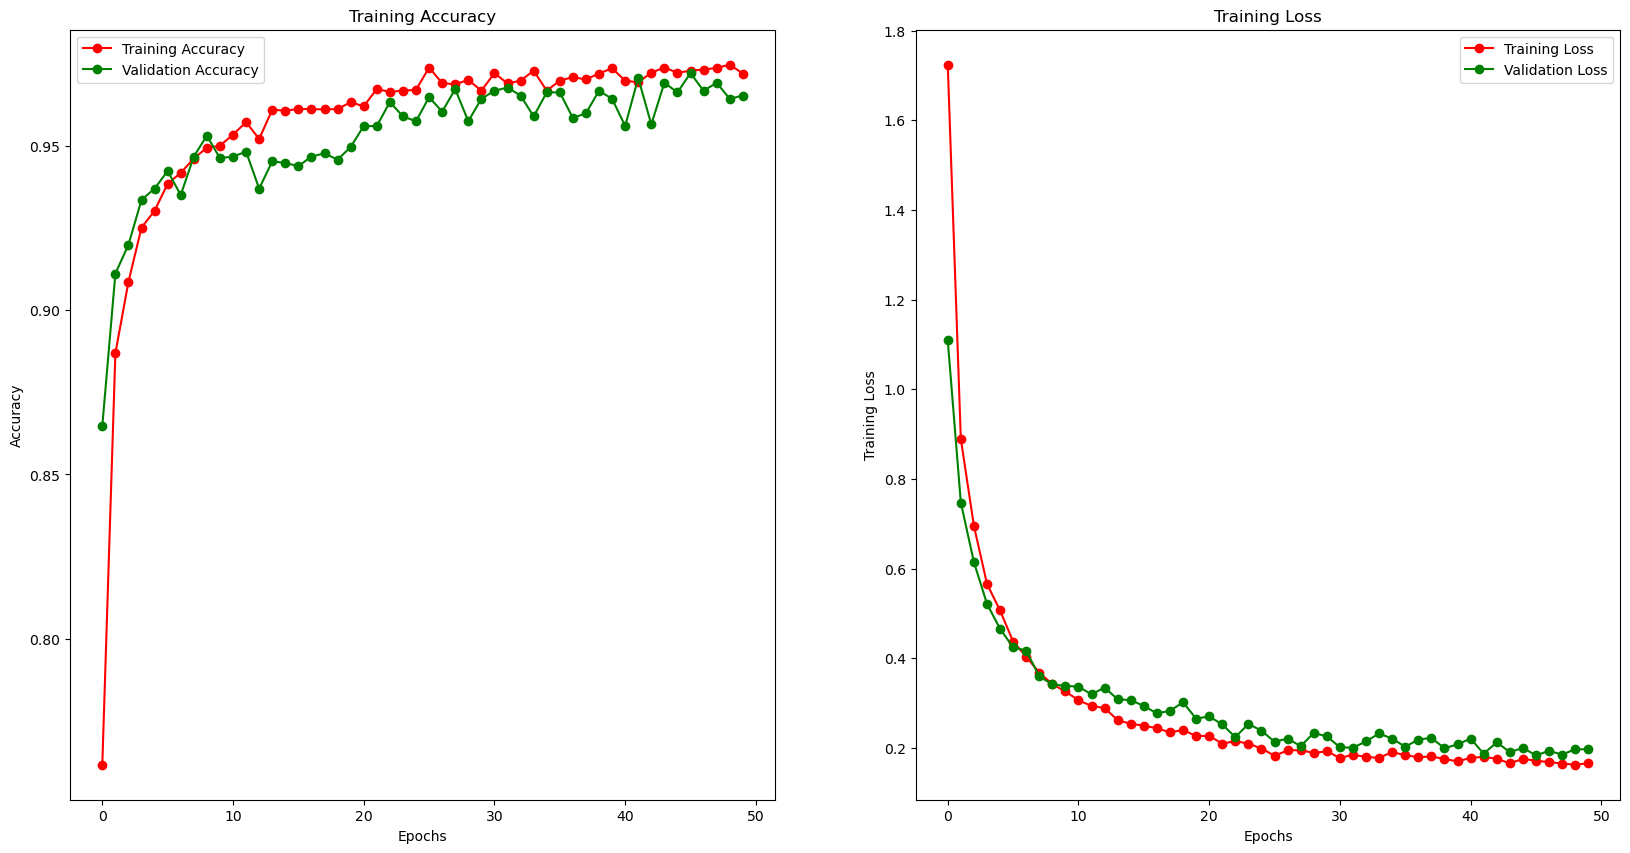

In [51]:
epochs = list(range(len(history.history['accuracy'])))
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' ,color='r', label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'go-' , label = 'Validation Accuracy')
ax[0].set_title('Training Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")


ax[1].plot(epochs , train_loss , 'g-o' ,color='r', label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'go-' , label = 'Validation Loss')
ax[1].set_title('Training Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training Loss")
plt.show()

# test datagen

In [52]:
class_=train_images.class_indices.keys()

In [53]:
test_generator = ImageDataGenerator(
    rescale=1.0 / 255,
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test,
    x_col='path',
    y_col='class_',
    target_size=(size, size),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
    subset='training'
)

Found 5534 validated image filenames belonging to 10 classes.


In [54]:
def prediction_generator(test_images):
    k=0
    for x in test_images:
        k+=len(x[1])
        yield [x[0],x[0]], x[1]
        if(k>=test_images.n):
            break

In [55]:
from sklearn.metrics import accuracy_score
proba=model.predict(prediction_generator(test_images))
predicted = np.argmax(proba,axis=1)
y_pred1=np.argmax(proba,axis=1)
true=test_images.labels
accuracy_score(predicted, true)

173/173 [==============================] - 215s 1s/step


0.9640404770509577

# confusion matrix

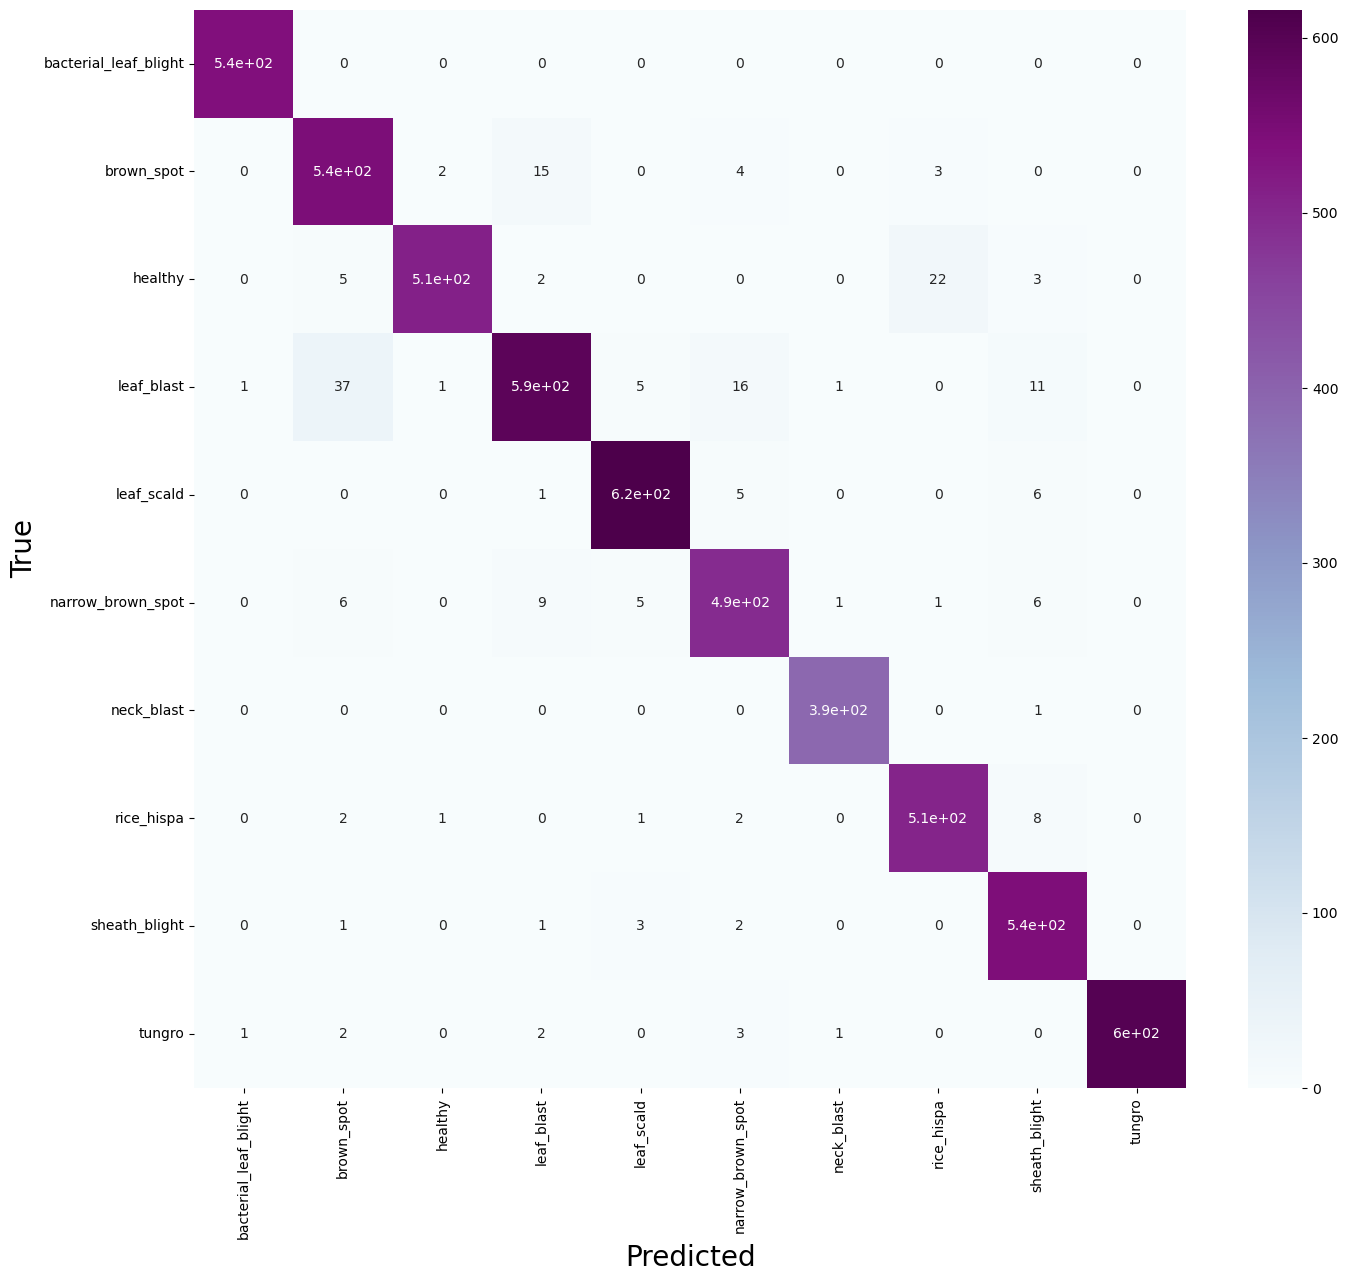

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
class_=test_images.class_indices.keys()
cm = confusion_matrix(true, predicted)
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,cmap="BuPu"); 
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)

ax.xaxis.set_ticklabels(class_, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_, fontsize = 10)
plt.yticks(rotation=0)

plt.title('', fontsize=60)

plt.savefig('ConMat24.png')
plt.show()

In [57]:
y_true = np.argmax(y_test, axis=1)

NameError: name 'y_test' is not defined

# ROC

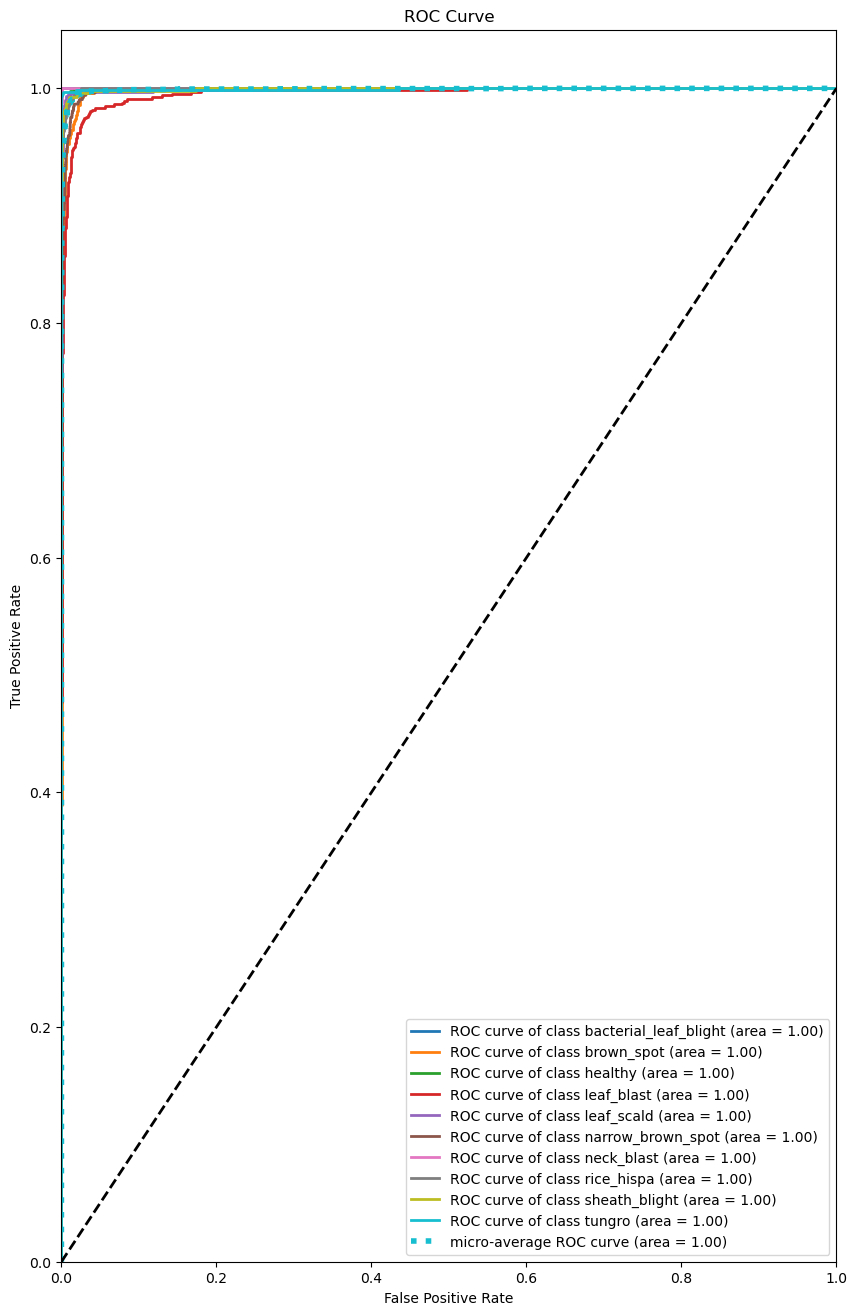

In [58]:
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import cm
n=len(true)
dim=max(true)+1
result=[]
for i in true:
    result.append([0 for i in range(dim)])
    result[len(result)-1][i]=1
    
    
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes =len(test_images.class_indices.keys())
y_test=np.array(result)
y_pred=np.array(proba)
fpr = dict()
tpr = dict()
roc_auc = dict()

rev={}
for i in class_:
    rev[train_images.class_indices[i]]=i


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = roc_auc_score(y_test[:, i], y_pred[:, i])


fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = roc_auc_score(y_test, y_pred, multi_class='ovr')


cmap = cm.get_cmap('tab10')

# Plot the ROC curve for each class and micro-average with automatic color selection
plt.figure(figsize=(10,16))
lw = 2
for i in range(n_classes):
    color = cmap(i)
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(rev[i], roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]),
         color=cmap(n_classes), linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# AUC

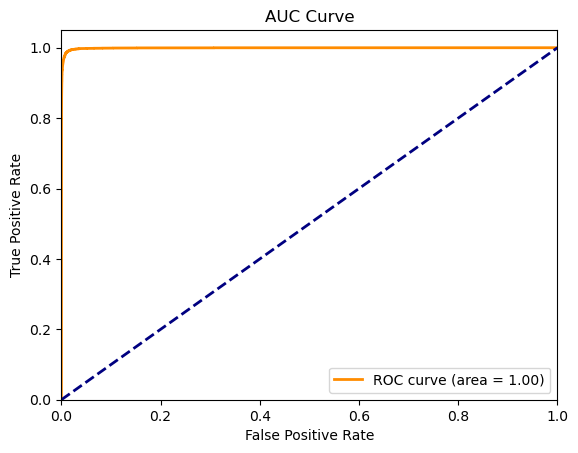

In [59]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_true=y_test
y_score=y_pred
fpr, tpr, thresholds = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC Curve')
plt.legend(loc="lower right")
plt.show()

In [60]:
y_true = np.argmax(y_test, axis=1)
y_score=y_pred

In [64]:
y_score

array([[1.14503629e-09, 2.73551459e-10, 1.63416100e-10, ...,
        9.95717375e-09, 9.99996185e-01, 1.92148311e-11],
       [7.67113350e-04, 5.96701689e-02, 8.02407980e-01, ...,
        1.34323081e-02, 2.40958040e-03, 2.29415833e-03],
       [4.50997504e-05, 1.09908422e-06, 7.34203240e-06, ...,
        4.77792298e-07, 8.25017105e-06, 3.10789968e-04],
       ...,
       [4.75834131e-05, 3.55589546e-05, 4.35775510e-05, ...,
        9.60570411e-04, 9.94761407e-01, 1.95275406e-05],
       [3.46370362e-04, 2.04612716e-05, 2.43666422e-04, ...,
        5.12439510e-06, 3.89844317e-05, 1.45987515e-05],
       [9.99945283e-01, 9.88388706e-07, 9.33103479e-07, ...,
        3.55333168e-06, 4.11729474e-07, 1.17480454e-06]], dtype=float32)

In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_true, y_pred1)
print(report)

In [61]:
from sklearn.metrics import classification_report
target_names = ['bacterial_leaf_blight', 'brown_spot', 'healthy','leaf_blast','leaf_scald','narrow_brown_spot','neck_blast','rice_hispa','sheath_blight','tungro']
print(classification_report(y_true, y_pred1, target_names=target_names))

                       precision    recall  f1-score   support

bacterial_leaf_blight       1.00      1.00      1.00       537
           brown_spot       0.91      0.96      0.93       568
              healthy       0.99      0.94      0.97       543
           leaf_blast       0.95      0.89      0.92       664
           leaf_scald       0.98      0.98      0.98       628
    narrow_brown_spot       0.94      0.95      0.94       522
           neck_blast       0.99      1.00      0.99       391
           rice_hispa       0.95      0.97      0.96       520
        sheath_blight       0.94      0.99      0.96       550
               tungro       1.00      0.99      0.99       611

             accuracy                           0.96      5534
            macro avg       0.97      0.97      0.97      5534
         weighted avg       0.96      0.96      0.96      5534

